## Final Project Module 3: Statistical Analysis and Hypothesis Testing


* Student name: Francis Morales
* Instructor name: Eli Thomas
* Blog post URL: 
* Presentation Link:


## Project Northwind Database

<img src="Northwind_ERD_updated.png" height="100%" width="100%">

In [2]:
# import libraries
import pandas as pd
import numpy as np
import sqlite3 as sql

import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
# Create a connection object that represents the database
cnx = sql.connect(r'Northwind_small.sqlite')
#Create a cursor instance to use execute/fetchall methods
c = cnx.cursor()

In [4]:
#Every SQLite database has an SQLITE_MASTER table that defines the schema for the database
#For tables, the type field will always be 'table' and the name field will be the name of the table
c.execute(''' SELECT name FROM sqlite_master WHERE type = 'table';''')

table_names = c.fetchall()
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [215]:
#get table column names 
c.execute("PRAGMA table_info('Customer')")
c.fetchall()

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'CompanyName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'ContactName', 'VARCHAR(8000)', 0, None, 0),
 (3, 'ContactTitle', 'VARCHAR(8000)', 0, None, 0),
 (4, 'Address', 'VARCHAR(8000)', 0, None, 0),
 (5, 'City', 'VARCHAR(8000)', 0, None, 0),
 (6, 'Region', 'VARCHAR(8000)', 0, None, 0),
 (7, 'PostalCode', 'VARCHAR(8000)', 0, None, 0),
 (8, 'Country', 'VARCHAR(8000)', 0, None, 0),
 (9, 'Phone', 'VARCHAR(8000)', 0, None, 0),
 (10, 'Fax', 'VARCHAR(8000)', 0, None, 0)]

In [340]:
#Plot sales over time
dataSalesoverTime = pd.read_sql_query('''SELECT strftime('%m-%Y', o.OrderDate) as Order_Date,
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'Total_Sales'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY Order_Date
                            ;''', cnx)

In [341]:
dataSalesoverTime['Order_Date'] = pd.to_datetime(dataSalesoverTime['Order_Date']) 

In [342]:
dataSalesoverTime.head()

,Order_Date,Total_Sales
0,2013-01-01,61258.0700
1,2014-01-01,94222.1105
2,2013-02-01,38483.6350
3,2014-02-01,99415.2875
4,2013-03-01,38547.2200


In [343]:
print(len(dataSalesoverTime['Total_Sales']))
print(dataSalesoverTime['Order_Date'].min())
print(dataSalesoverTime['Order_Date'].max())
# print(dataSalesoverTime['ValDate'].mid())

23
2012-07-01 00:00:00
2014-05-01 00:00:00


C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


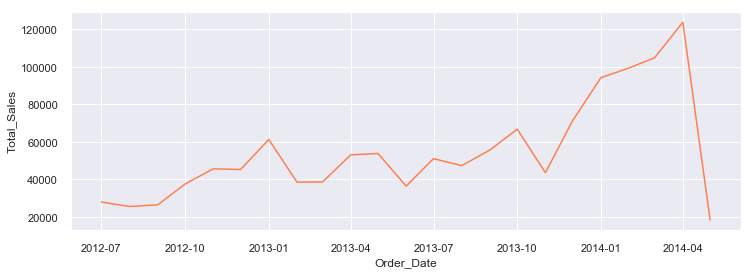

In [361]:
#Plot sales over time
plt.figure(figsize=(12, 4))
ax = sns.lineplot(x="Order_Date", y="Total_Sales", data=dataSalesoverTime, c='coral')

In [352]:
#What is the total number of Customers the company has?
dfTotalCustomers = pd.read_sql_query('''SELECT DISTINCT Id FROM 'Customer'
                            ;''', cnx)

In [354]:
len(dfTotalCustomers['Id'])

91

In [356]:
#What is the total number of Products the company offer?
dfTotalProduct = pd.read_sql_query('''SELECT DISTINCT Id FROM 'Product'
                            ;''', cnx)

In [357]:
len(dfTotalProduct['Id'])

77

# Hypothesis 1 - Do customers with more orders placed generate higher sales amounts?
- $H_0: \mu_1 = \mu_2$ Customers with more orders placed spend the same amount on average as customers with less orders placed
- $H_a: \mu_1 > \mu_2$ Customers with more orders placed spend more than customers with less orders placed

## Exp 1: Data Exploration

In [391]:
#Get the total sales amount per customer ID
#Get the count of number of orders placed by customer

data1 = pd.read_sql_query('''SELECT o.CustomerId, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount',
                            COUNT(o.Id) as 'CountOrders'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.CustomerId
                            ;''', cnx)

In [392]:
#get the median of frequency orders to create the samples
data1['CountOrders'].median()

20.0

In [393]:
#create 2 sample groups 
#sample groups are divided by the median order frequency (our independent variable)
#This will allow to check if the TotalAmount means between groups are significantly different
high_frequency = data1.loc[data1['CountOrders'] > data1['CountOrders'].median()]
low_frequency = data1.loc[data1['CountOrders'] <= data1['CountOrders'].median()]

##### Histogram to check normality

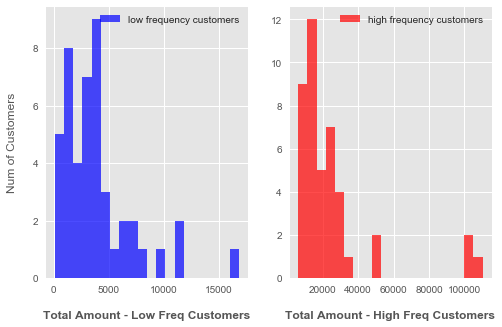

In [121]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

ax1.hist(low_frequency['TotalAmount'], bins=20, color='b', alpha=0.7, label='low frequency customers')
ax1.set_xlabel('\nTotal Amount - Low Freq Customers', fontweight='bold')
ax1.set_ylabel('Num of Customers\n')
ax1.legend()

ax2.hist(high_frequency['TotalAmount'], bins=20, color='r', alpha=0.7, label='high frequency customers')
ax2.set_xlabel('\nTotal Amount - High Freq Customers', fontweight='bold')
ax2.legend();

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [254]:
print(scs.shapiro(high_frequency['TotalAmount']), scs.shapiro(low_frequency['TotalAmount']))

NameError: name 'high_frequency' is not defined

> With p-values below the alpha level (0.05) we reject H0 and have significant evidence to assume that the samples do not follow a normal distribution.

##### Levene test to check for equal variances
- H0: v1=v2

- Ha: v1!=v2

In [13]:
# Levene Test for testing homogeneity of variances
# I will be evaluating if the total amount comes from a normal distribution

scs.levene(high_frequency['TotalAmount'], low_frequency['TotalAmount'])

LeveneResult(statistic=11.818379956321802, pvalue=0.0009019045930232378)

> We have significant evidence to reject H0 and conclude that the variances in the samples are different.
Since the variances between the two groups are not equal, we cannot use a T-test

## Exp 1: Monte Carlo Simulation

**After inspection of the sample distributions we determined that a non-parametric method will be used since the sample distributions do not comply with the normality and equal variance assumptions.**

In [14]:
#get the mean difference 
mean_diff = high_frequency['TotalAmount'].mean() - low_frequency['TotalAmount'].mean()
mean_diff

21086.921466632968

- On average, high frequency customers spent $21086 more than low frequency customers.
- We will take 10000 random sample mean differences from our data and check if the random mean difference is greater than the study mean difference (high_frequency - low_frequency).
- If not many random sample mean differences are greater than the study mean difference, then we can conclude that the study mean difference is not due to chance
- We also calculate the p-value to check the percentage of random mean differences that are greater than the study mean difference

In [15]:
#Monte Carlo Simulation
sample_diffs = []
counter = 0

for i in range(10000):
    sample_high = data1.sample(replace=False, n=len(high_frequency['TotalAmount']))
    sample_low = data1.drop(sample_high.index, axis=0)
    sample_diff = sample_high['TotalAmount'].mean() - sample_low['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

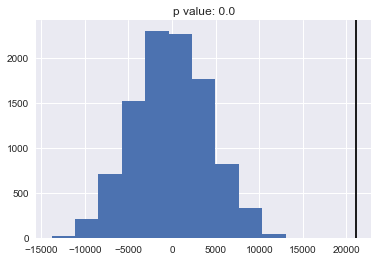

In [16]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p value: {np.round(counter / 10000, 3)}');

## Exp 2: Data Exploration
- Given the results from experiment 1, an additional experiment will be performed to confirm hypothesis
- For this experiment, we will analyze if the low frequency sample group was influenced by the new customer onboarding date

In [399]:
#DataFrame with order Id details and Order Date
#This will help explore further the frequency of customers
data2 = pd.read_sql_query('''SELECT o.Id, o.CustomerId, o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.Id
                            ;''', cnx)

In [400]:
data2['OrderDate'] = pd.to_datetime(data2['OrderDate'])

In [401]:
data2.head()

,Id,CustomerId,OrderDate,TotalAmount
0,10248,VINET,2012-07-04,440.00
1,10249,TOMSP,2012-07-05,1863.40
2,10250,HANAR,2012-07-08,1552.60
3,10251,VICTE,2012-07-08,654.06
4,10252,SUPRD,2012-07-09,3597.90


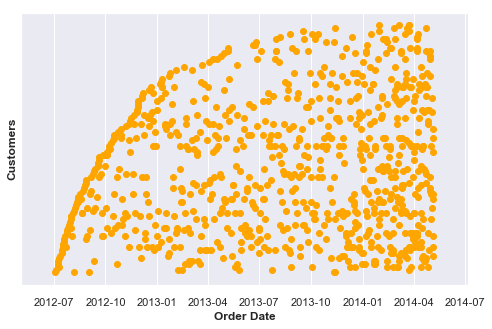

In [305]:
#Plot sales over time for all customers
plt.figure(figsize=(8, 5))
sc = plt.scatter(data2['OrderDate'], data2['CustomerId'], marker='o', c='orange')
plt.yticks([])
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('Customers', fontweight='bold')
plt.show()

In [402]:
#select the customer IDs from the high and low frequency from the second dataset
High_freq = data2.loc[data2['CustomerId'].isin(high_frequency['CustomerId'])]
Low_freq = data2.loc[data2['CustomerId'].isin(low_frequency['CustomerId'])]

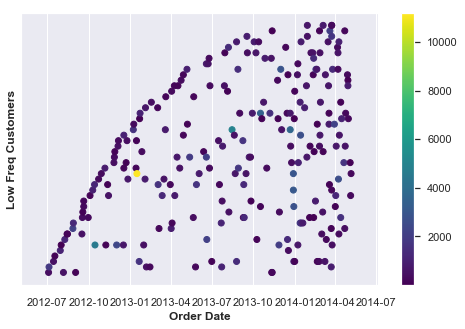

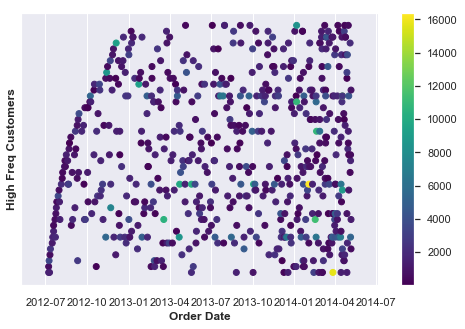

In [407]:
#Plot of random sample of low frequency and hight frequency customers 
plt.figure(figsize=(8, 5))
sc = plt.scatter(Low_freq['OrderDate'], Low_freq['CustomerId'], marker='o', c=Low_freq['TotalAmount'], cmap='viridis', vmin=Low_freq['TotalAmount'].min(), vmax=Low_freq['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('Low Freq Customers', fontweight='bold')
plt.yticks([])
plt.colorbar(sc)
plt.show()

plt.figure(figsize=(8, 5))
sc2 = plt.scatter(High_freq['OrderDate'], High_freq['CustomerId'], marker='o', c=High_freq['TotalAmount'], cmap='viridis', vmin=High_freq['TotalAmount'].min(), vmax=High_freq['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('High Freq Customers', fontweight='bold')
plt.yticks([])
plt.colorbar(sc2)
plt.show()

> The plotted order IDs vs customer shows that there might be an influence in the number of orders by the date the customer started working with our store. We will make the assumption that most of the customers started working with Northwind by 07-2013 and we will do the hypothesis test on the new sample. 

##### Select new sample

Selecting orders placed after 2013-07-01 since 97% of the customers had placed at least one order by then

In [409]:
#Only orders places after 07-2013 will be considered
#Get the total sales amount per customer ID
#Get the count of number of orders placed by customer

data3 = pd.read_sql_query('''SELECT o.CustomerId, o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount',
                            COUNT(o.Id) as 'CountOrders'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            WHERE o.OrderDate > '2013-07-01'
                            GROUP BY o.CustomerId
                            ;''', cnx) 

In [413]:
data3['OrderDate'] = pd.to_datetime(data3['OrderDate'])

In [414]:
data3['CountOrders'].median()

11.0

In [415]:
#create 2 sample groups 
#sample groups are divided by the median order frequency (our independent variable)
#This will allow to check if the TotalAmount means between groups are significantly different
high_frequency2 = data3.loc[data1['CountOrders'] > data3['CountOrders'].median()]
low_frequency2 = data3.loc[data1['CountOrders'] <= data3['CountOrders'].median()]

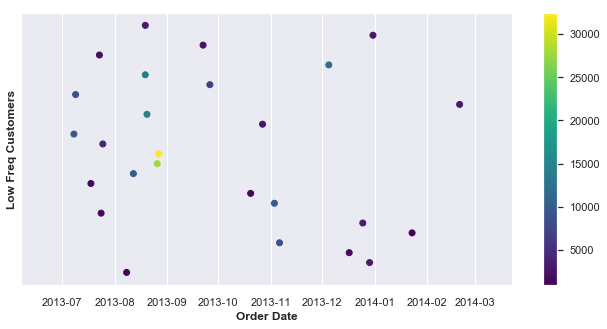

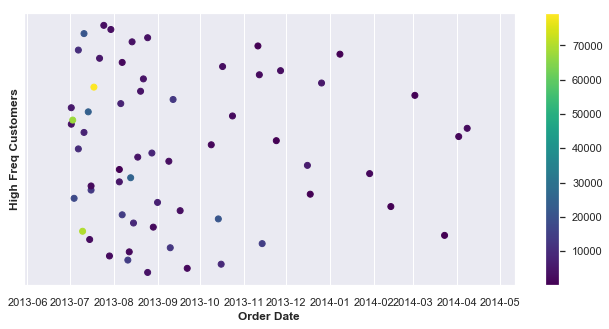

In [419]:
#Plot of random sample of low frequency and hight frequency customers 
plt.figure(figsize=(11, 5))
sc = plt.scatter(low_frequency2['OrderDate'], low_frequency2['CustomerId'], marker='o', c=low_frequency2['TotalAmount'], cmap='viridis', vmin=low_frequency2['TotalAmount'].min(), vmax=low_frequency2['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('Low Freq Customers', fontweight='bold')
plt.yticks([])
plt.colorbar(sc)
plt.show()

plt.figure(figsize=(11, 5))
sc2 = plt.scatter(high_frequency2['OrderDate'], high_frequency2['CustomerId'], marker='o', c=high_frequency2['TotalAmount'], cmap='viridis', vmin=high_frequency2['TotalAmount'].min(), vmax=high_frequency2['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('High Freq Customers', fontweight='bold')
plt.yticks([])
plt.colorbar(sc2)
plt.show()

##### Histogram to check normality

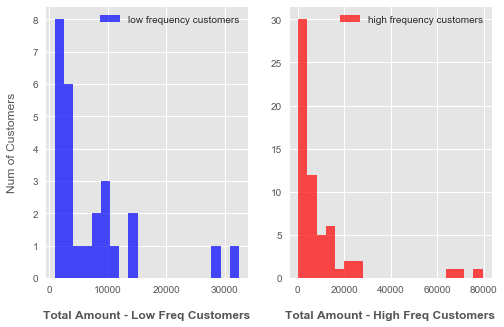

In [122]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

ax1.hist(low_frequency2['TotalAmount'], bins=20, color='b', alpha=0.7, label='low frequency customers')
ax1.set_xlabel('\nTotal Amount - Low Freq Customers', fontweight='bold')
ax1.set_ylabel('Num of Customers\n')
ax1.legend()

ax2.hist(high_frequency2['TotalAmount'], bins=20, color='r', alpha=0.7, label='high frequency customers')
ax2.set_xlabel('\nTotal Amount - High Freq Customers', fontweight='bold')
ax2.legend();

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [124]:
print(scs.shapiro(high_frequency2['TotalAmount']), scs.shapiro(low_frequency2['TotalAmount']))

(0.5477457046508789, 2.0006945319200886e-12) (0.7365228533744812, 1.7483718693256378e-05)


> With p-values below the alpha level (0.05) we reject H0 and have significant evidence to assume that the samples do not follow a normal distribution.

## Exp 2: Monte Carlo Simulation
After inspection of the sample distributions we determined that a non-parametric method will be used since the sample distributions do not comply with the normality and equal variance assumptions.

In [420]:
#get the mean difference 
mean_diff = high_frequency2['TotalAmount'].mean() - low_frequency2['TotalAmount'].mean()
mean_diff

2374.1676131778077

- On average, high frequency customers spent $2374 more than low frequency customers.
- We will take 10000 random sample mean differences from our data and check if the random mean difference is greater than the study mean difference (high_frequency - low_frequency).
- If not many random sample mean differences are greater than the study mean difference, then we can conclude that the study mean difference is not due to chance
- We also calculate the p-value to check the percentage of random mean differences that are greater than the study mean difference

In [49]:
#Monte Carlo Simulation
sample_diffs = []
counter = 0
for i in range(10000):
    sample_high = data3.sample(replace=False, n=len(high_frequency['TotalAmount']))
    sample_low = data3.drop(sample_high.index, axis=0)
    sample_diff = sample_high['TotalAmount'].mean() - sample_low['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

NameError: name 'data3' is not defined

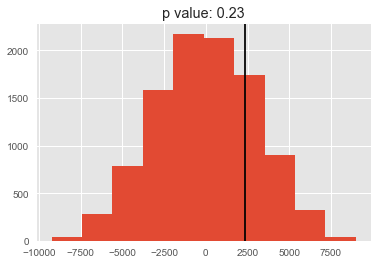

In [127]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p value: {np.round(counter / 10000, 3)}');

## Conclusions, Business Recommendations & Future Work

##### Conclusions
EXPERIMENT 1
- A Shapiro test and a Levene test were used to check normality and equal variance assumptions. The results from these tests along with the plotted histograms confirmed that the data did not come from a normal distribution 
- A Monte Carlo simulation was used to evaluate our hypothesis and ensure reliable results
- P-value = 0.0, therefore we have significant evidence to reject H0
- The conclusion of this experiment is that customers with more orders placed spend more than customers with less orders placed; nevertheless, an additional experiment was performed to ensure that these results were not influenced by the customer's first order date



EXPERIMENT 2

- An initial assumption was made for this experiment: 97% of the customers had placed an order by 07-2013, therefore we only considered orders placed after that date for experiment 2
- A Shapiro test and a histogram were used to test normality on the samples. The tests showed that the normality assumption was not met, therefore a non-parametric hypothesis test was used for experiment 2.
- A Monte Carlo simulation was used to evaluate our hypothesis and ensure reliable results
- P-value = 0.23, therefore we do not have significant evidence to reject H0.
- The conclusion of this experiment is that frequency of customer purchases does not have a significant influence in the sales amount of Northwind.  

##### Business Recommendations
- The same marketing scheme can be used for both high frequency and low frequency customers
- Invest money on new customer on-boarding
- Consider creating a strategy geared to drive customers to make larger orders rather than more frequent ones in order to decrease shipping costs and order handling costs

##### Future Work
- Study customer retention
- Study what is the rate of growth in the number of new customers
- Growth of new customers per office (USA vs UK). Confirm if there is an office getting significantly more new customers.
- Study if discounted items campaigns affect customer frequency
- Check if shipping costs and order handling costs are significantly different between high frequency purchase customers and low frequency purchase customers
- Study the rate of purchases per customer

# Hypothesis 2 - Which employees have better customer service practices? (translated in direct sales)
- $H_0: \mu_1 = \mu_2$ Sales amount is the same for USA and UK employees
- $H_a: \mu_1 > \mu_2$ USA employees sales amount is higher than UK employees sales amount

We will study the sales by employee country rather than by customer country. Our interest with this hypothesis will be confirming if office best practices affect customer interactions reflected in an increase of sales 

## Data Exploration

In [16]:
c.execute("PRAGMA table_info('Employee')")
c.fetchall()

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'LastName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'FirstName', 'VARCHAR(8000)', 0, None, 0),
 (3, 'Title', 'VARCHAR(8000)', 0, None, 0),
 (4, 'TitleOfCourtesy', 'VARCHAR(8000)', 0, None, 0),
 (5, 'BirthDate', 'VARCHAR(8000)', 0, None, 0),
 (6, 'HireDate', 'VARCHAR(8000)', 0, None, 0),
 (7, 'Address', 'VARCHAR(8000)', 0, None, 0),
 (8, 'City', 'VARCHAR(8000)', 0, None, 0),
 (9, 'Region', 'VARCHAR(8000)', 0, None, 0),
 (10, 'PostalCode', 'VARCHAR(8000)', 0, None, 0),
 (11, 'Country', 'VARCHAR(8000)', 0, None, 0),
 (12, 'HomePhone', 'VARCHAR(8000)', 0, None, 0),
 (13, 'Extension', 'VARCHAR(8000)', 0, None, 0),
 (14, 'Photo', 'BLOB', 0, None, 0),
 (15, 'Notes', 'VARCHAR(8000)', 0, None, 0),
 (16, 'ReportsTo', 'INTEGER', 0, None, 0),
 (17, 'PhotoPath', 'VARCHAR(8000)', 0, None, 0)]

In [151]:
#Check the number of countries for employeeID 1
dataEmp1 = pd.read_sql_query('''SELECT e.Id as 'EmployeeId', e.Country, c.Country
                            FROM 'Employee' e
                            JOIN 'Order' o ON e.Id = o.EmployeeId
                            JOIN 'Customer' c ON c.Id = o.CustomerId
                            WHERE e.Id = 1
                            ;''', cnx)

In [152]:
dataEmp1.head(20)

,EmployeeId,Country,Country
0,1,USA,Austria
1,1,USA,Finland
2,1,USA,Italy
3,1,USA,Germany
4,1,USA,Brazil
5,1,USA,Mexico
6,1,USA,Mexico
7,1,USA,Spain
8,1,USA,USA
9,1,USA,USA


In [280]:
#Check the number of unique countries each employee handles 
dataEmpId = pd.read_sql_query('''SELECT e.Id as 'EmployeeId', e.Country,
                            COUNT (DISTINCT c.Country) as 'Customer_Countries_Count'
                            FROM 'Employee' e
                            JOIN 'Order' o ON e.Id = o.EmployeeId
                            JOIN 'Customer' c ON c.Id = o.CustomerId
                            GROUP BY e.Id
                            ;''', cnx)

In [273]:
dataEmpId.head(2)

,EmployeeId,Country,Customer Countries
0,1,USA,21
1,2,USA,18


In [282]:
#Check mean number of customers per Employee Office
USA = dataEmpId.loc[dataEmpId['Country'] == 'USA']
UK = dataEmpId.loc[dataEmpId['Country'] == 'UK']
print(USA['Customer_Countries_Count'].mean())
print(UK['Customer_Countries_Count'].mean())


19.4
17.25


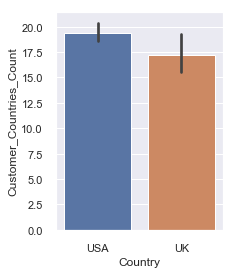

In [289]:
#Visualize the mean number of customers per office USA vs UK
plt.figure(figsize=(3,4))
ax = sns.barplot(x="Country", y="Customer_Countries_Count", data=dataEmpId)

In [266]:
#Visualize the number of employees per country
#Divide the countries by UK vs USA employees
dataCountryEmpl = pd.read_sql_query('''SELECT e.Country as 'Employee_Country', c.Country as 'Customer_Country',
                            COUNT (DISTINCT e.Id) as 'Employee_Count'
                            FROM 'Employee' e
                            JOIN 'Order' o ON e.Id = o.EmployeeId
                            JOIN 'Customer' c ON c.Id = o.CustomerId
                            GROUP BY e.Country, c.Country
                            ;''', cnx)

In [267]:
dataCountryEmpl.head(3)

,Employee_Country,Customer_Country,Employee_Count
0,UK,Argentina,3
1,UK,Austria,3
2,UK,Belgium,4


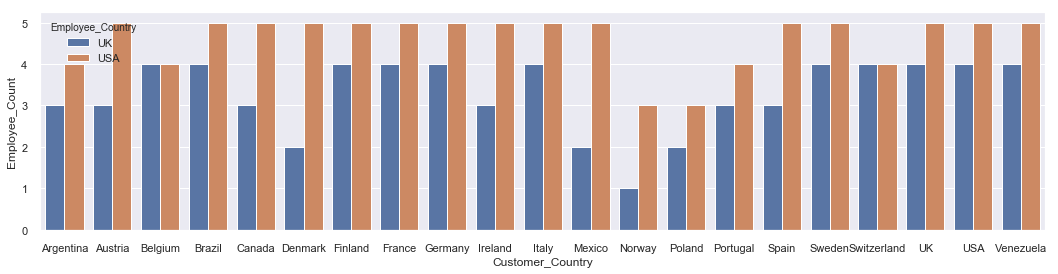

In [271]:
sns.set(color_codes=True)
# sns.set(style="whitegrid")
plt.figure(figsize=(18,4))
ax = sns.barplot(x="Customer_Country", y="Employee_Count", hue="Employee_Country", data=dataCountryEmpl)

> As you can see from the graph, both USA and UK offices work with all of the countries Northwind provides services to. We will investigate forward to see if there is a significant difference between office best practices that directly affect sales.

In [365]:
#Check the sales over time for USA and UK
#Plot sales over time
dataSalesTimeUSAUK = pd.read_sql_query('''SELECT strftime('%m-%Y', o.OrderDate) as Order_Date, e.Country,
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'Total_Sales'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            JOIN 'Employee' e ON e.Id = o.EmployeeId
                            GROUP BY Order_Date, e.Country
                            ;''', cnx)

In [368]:
dataSalesTimeUSAUK['Order_Date'] = pd.to_datetime(dataSalesTimeUSAUK['Order_Date']) 

In [369]:
dataSalesTimeUSAUK.head(2)

,Order_Date,Country,Total_Sales
0,2013-01-01,UK,13564.14
1,2013-01-01,USA,47693.93


In [387]:
USA = dataSalesTimeUSAUK.loc[dataSalesTimeUSAUK['Country'] == 'USA']
UK = dataSalesTimeUSAUK.loc[dataSalesTimeUSAUK['Country'] == 'UK']

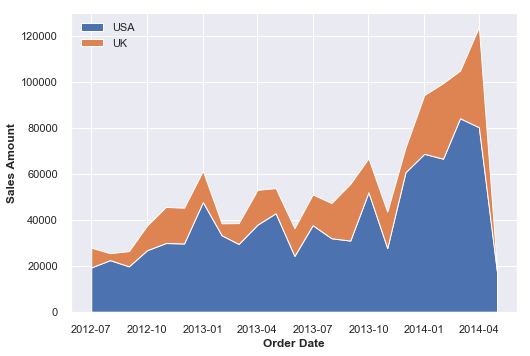

In [388]:
# Area chart showing total sales of Northwind Traders
#Area at each date is divided by the area coming from USA and area coming from UK
USA = USA.sort_values(by=['Order_Date'])
UK = UK.sort_values(by=['Order_Date'])

x=USA['Order_Date']
y=[USA['Total_Sales'],UK['Total_Sales']]
 
# Plot
plt.stackplot(x,y, labels=['USA','UK'])
plt.legend(loc='upper left')
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('Sales Amount', fontweight='bold')
plt.show()


> Above stack plot shows the total sales over time of Northwind Traders divided by the proportion brought by USA team and UK team. It is visible that the sales amount brought by the USA team is consistently higher than the UK team. 

In [158]:
#Create DataFrame for Hypothesis 2
#After visualizing the spread of countries between employees from USA and UK we will analize the difference in sales
#between employee country
dataUSUK = pd.read_sql_query('''SELECT e.Id as 'EmployeeId', e.Country, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Employee' e
                            JOIN 'Order' o ON e.Id = o.EmployeeId
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY e.Id
                            ;''', cnx)

In [159]:
dataUSUK.head()

,EmployeeId,Country,TotalAmount
0,1,USA,192107.6045
1,2,USA,166537.7550
2,3,USA,202812.8430
3,4,USA,232890.8460
4,5,UK,68792.2825


In [160]:
dataUSUK['Country'].value_counts()

USA    5
UK     4
Name: Country, dtype: int64

In [161]:
#create specific dataframes for each country
dfUSA = dataUSUK.loc[dataUSUK['Country'] == 'USA']
dfUK = dataUSUK.loc[dataUSUK['Country'] == 'UK']

##### Histogram to check normality

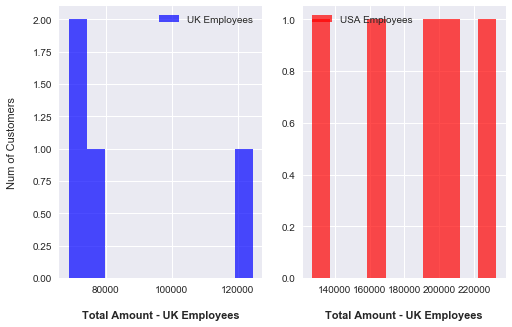

In [42]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

ax1.hist(dfUK['TotalAmount'], color='b', alpha=0.7, label='UK Employees')
ax1.set_xlabel('\nTotal Amount - UK Employees', fontweight='bold')
ax1.set_ylabel('Num of Customers\n')
ax1.legend()

ax2.hist(dfUSA['TotalAmount'], color='r', alpha=0.7, label='USA Employees')
ax2.set_xlabel('\nTotal Amount - UK Employees', fontweight='bold')
ax2.legend();

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [43]:
print(scs.shapiro(dfUK['TotalAmount']), scs.shapiro(dfUSA['TotalAmount']))

(0.7545575499534607, 0.042571838945150375) (0.9839245080947876, 0.9544581174850464)


> dfUK has a p-value of 0.04, therefore we nahe enough evidence to reject H0 (dfUK does NOT come from a normal distribution). We will use a non-parametric test

## Monte Carlo Simulation

**After inspection of the sample distributions we determined that a non-parametric method will be used since the sample distributions do not comply with the normality assumption.**

In [45]:
#get the mean difference 
mean_diff = dfUSA['TotalAmount'].mean() - dfUK['TotalAmount'].mean()
mean_diff

98096.83682499999

In [47]:
#Monte Carlo Simulation
sample_diffs = []
counter = 0

for i in range(10000):
    sampleUSA = data4.sample(replace=False, n=len(dfUSA['TotalAmount']))
    sampleUK = data4.drop(sampleUSA.index, axis=0)
    sample_diff = sampleUSA['TotalAmount'].mean() - sampleUK['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

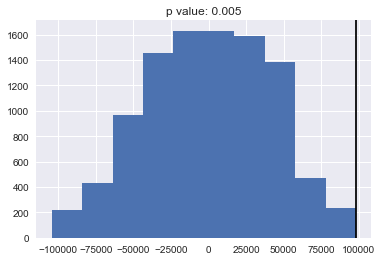

In [48]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p value: {np.round(counter / 10000, 3)}');

## Conclusions, Business Recommendations & Future Work

##### Conclusions
- A Shapiro test and a histogram were used to test normality on the samples. The tests showed that the normality assumption was not met, therefore a non-parametric hypothesis test was used for this experiment.
- A Monte Carlo simulation was used to evaluate our hypothesis and ensure reliable results
- P-value = 0.05, therefore we do have significant evidence to reject H0.
- The conclusion of this experiment is that customers that work with USA employees significantly bring more sales to Northwind that the customers that work with UK employees

##### Business Recommendations
- Identify the best practices USA employees are using to drive higher sales and leverage those in the UK
- Investigate why there is a difference between the mean number of customers USA employees and UK employees work with
- Further investgate the customer profiles to target an increase in sales

##### Future Work
- Further investigate each customer and create profiles for them based on sales and product purchases
- Check if there are significant differences in sales between customers from the same country in order to evaluate the possibility of target marketing campaigns

# Hypothesis 3 - Are PId60* and PId71* usually purchased together?
- H0: PId60 mean units sold when PId71 is purchased =< PId60 mean units sold when PId71 is NOT purchased (difference between means = zero)

> $H_0: \mu_d =< 0$

- Ha: PId60 mean units sold when PId71 is purchased > PId60 mean units sold when PId71 is NOT purchased

> $H_a:  \mu_d > 0$


- PId = Product Id*
- Since I specify the direction of the difference, it's a **one-tailed** test
- PId60 is the best seller of Northwind
- PId71 is the best seller among orders that contain PId60
- Population for this test is all orders that contain PId60

## Data Exploration

In [86]:
#Find out what the best seller product is
dfBestSeller = pd.read_sql_query('''SELECT od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, 
                            SUM(od.Quantity) as 'UnitsSold'
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            GROUP BY od.ProductId
                            ;''', cnx)

In [87]:
dfBestSeller.sort_values(by='UnitsSold', ascending=False)

,ProductId,ProductName,CategoryId,CategoryName,UnitsSold
59,60,Camembert Pierrot,4,Dairy Products,1577
58,59,Raclette Courdavault,4,Dairy Products,1496
30,31,Gorgonzola Telino,4,Dairy Products,1397
55,56,Gnocchi di nonna Alice,5,Grains/Cereals,1263
15,16,Pavlova,3,Confections,1158
74,75,Rhönbräu Klosterbier,1,Beverages,1155
23,24,Guaraná Fantástica,1,Beverages,1125
39,40,Boston Crab Meat,8,Seafood,1103
61,62,Tarte au sucre,3,Confections,1083
70,71,Flotemysost,4,Dairy Products,1057


In [98]:
dfBestSeller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
ProductId       77 non-null int64
ProductName     77 non-null object
CategoryId      77 non-null int64
CategoryName    77 non-null object
UnitsSold       77 non-null int64
dtypes: int64(3), object(2)
memory usage: 3.1+ KB


> - There are 77 different products in the company. 
> - The best seller is  ProductId= 60-'Camembert Pierrot' with 1577 units sold.
> - Will find all the OrderIds that contain ProductId= 60-'Camembert Pierrot' and find the most frequent product bought with it

In [88]:
#Get all OrderIds that contain ProductId = 60
dfP60_OrderIds = pd.read_sql_query('''SELECT od.OrderId
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            WHERE ProductId = 60
                            ;''', cnx)

In [150]:
dfP60_OrderIds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 1 columns):
OrderId    51 non-null int64
dtypes: int64(1)
memory usage: 488.0 bytes


In [103]:
#Find all the ProductIds and the quantities sold for all the OrderIds that contained ProductId=60
#This will help find the product most selled with P60
dfBestSeller2 = pd.read_sql_query('''SELECT od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, od.Discount,
                            SUM(od.Quantity) as 'UnitsSold'
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            WHERE od.OrderId IN 
                                (SELECT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 60)
                            GROUP BY od.ProductId
                            ;''', cnx)

In [104]:
dfBestSeller2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
ProductId       63 non-null int64
ProductName     63 non-null object
CategoryId      63 non-null int64
CategoryName    63 non-null object
Discount        63 non-null float64
UnitsSold       63 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.0+ KB


In [92]:
#Find the product that was paired the most times with ProductId=60
dfBestSeller2.sort_values(by='UnitsSold', ascending=False)

,ProductId,ProductName,CategoryId,CategoryName,UnitsSold
49,60,Camembert Pierrot,4,Dairy Products,1577
57,71,Flotemysost,4,Dairy Products,197
13,16,Pavlova,3,Confections,196
33,40,Boston Crab Meat,8,Seafood,187
25,31,Gorgonzola Telino,4,Dairy Products,165
0,1,Chai,1,Beverages,164
22,27,Schoggi Schokolade,3,Confections,135
20,24,Guaraná Fantástica,1,Beverages,132
32,39,Chartreuse verte,1,Beverages,129
8,10,Ikura,8,Seafood,117


> - ProductId=71-'Flotemysost' was the product most frequently bought with ProductId=60
> - Need to determine if the purchase of P71 increases the sales in P60

In [93]:
#Get the OrderIds where P60 and P71
#This will help classify the orderIds where P71 = yes or P71 = no
dfP71_OrderId = pd.read_sql_query('''SELECT DISTINCT od.OrderId 
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            WHERE od.OrderId IN 
                                (SELECT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 60)
                            AND od.OrderId IN 
                                (SELECT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 71)
                            ;''', cnx)

In [94]:
dfP71_OrderId.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 1 columns):
OrderId    6 non-null int64
dtypes: int64(1)
memory usage: 128.0 bytes


In [106]:
#Will take Quantity of PId60 in orders containing PId71 and orders without PId71
#This will let us compare if the purchase of PId71 influences the quantity of PId60 purchased
dfP60vsP71 = pd.read_sql_query('''SELECT od.OrderId, od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, od.Discount,
                            od.Quantity
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            WHERE od.OrderId IN 
                                (SELECT DISTINCT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 60)
                            AND od.ProductId = 60
                            ;''', cnx)

In [101]:
dfP60vsP71.head()

,OrderId,ProductId,ProductName,CategoryId,CategoryName,Quantity
0,10252,60,Camembert Pierrot,4,Dairy Products,40
1,10283,60,Camembert Pierrot,4,Dairy Products,35
2,10284,60,Camembert Pierrot,4,Dairy Products,20
3,10294,60,Camembert Pierrot,4,Dairy Products,21
4,10357,60,Camembert Pierrot,4,Dairy Products,8


In [96]:
#Divide PId60 orders with PId71 and without PId71
dfwithP71 = dfP60vsP71.loc[dfP60vsP71['OrderId'].isin(list(dfP71_OrderId['OrderId']))]
dfwoP71 = dfP60vsP71.loc[~dfP60vsP71['OrderId'].isin(list(dfP71_OrderId['OrderId']))]

In [242]:
print(dfwithP71.shape, dfwoP71.shape)

(6, 6) (45, 6)


In [243]:
mu_withP71, mu_woP71 = np.mean(dfwithP71['Quantity']), np.mean( dfwoP71['Quantity'])
print(mu_withP71, mu_woP71)

39.166666666666664 29.822222222222223


In [244]:
sd_withP71, sd_woP71 = np.std(dfwithP71['Quantity']), np.std(dfwoP71['Quantity'])
print(sd_withP71, sd_woP71)

18.451889394374287 23.153870700059237


> From the sample  average and standard deviations we can see that the two groups are not so close in numbers. Need to investigate further to confirm if there is a real existing difference between groups.

##### Histogram to check normality

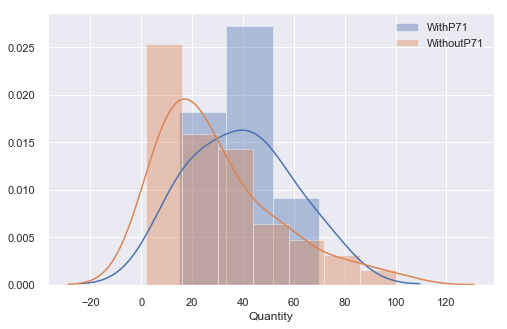

In [255]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,5)})
sns.distplot(dfwithP71['Quantity'], label='WithP71')
sns.distplot(dfwoP71['Quantity'], label='WithoutP71') 
plt.legend()
plt.show();

##### Check Outliers

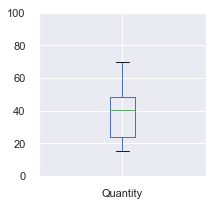

In [272]:
dfwithP71['Quantity'].plot(kind='box', ylim=(0, 100), figsize=(3,3));

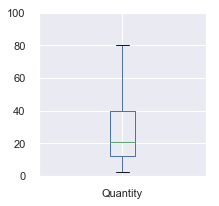

In [273]:
dfwoP71['Quantity'].plot(kind='box', ylim=(0, 100), figsize=(3,3));

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [102]:
print(scs.shapiro(dfwithP71['Quantity']), scs.shapiro(dfwoP71['Quantity']))

(0.9605991244316101, 0.8243460655212402) (0.8918686509132385, 0.0005341130308806896)


##### Levene test to check for equal variances
- H0: v1=v2

- Ha: v1!=v2

In [257]:
scs.levene(dfwithP71['Quantity'], dfwoP71['Quantity'])

LeveneResult(statistic=0.06407726897311178, pvalue=0.801223004740049)

## Welch's T-Test
- I will use a Welch's T-Test since my samples are not of equal size. 
- dfwithP71 passed the test for normality, dfwoP71 did not pass it. 
- Eventhough dfwoP71 did not come from a normal dustribution, I will continue using Welch's T-test since it remains robust for skewed distributions.

In [329]:
def Welch_test(a, b):
    numerator = a.mean() - b.mean()
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

In [326]:
def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    return numerator/denominator

In [335]:
t = Welch_test(dfwithP71['Quantity'], dfwoP71['Quantity'])
t

1.0429263972500478

In [336]:
df = welch_df(dfwithP71['Quantity'], dfwoP71['Quantity'])
df

6.924186837860065

In [334]:
#get the p-value with calculated t statistic and df
p = 1 - scs.t.cdf(t, df)
print(p)

0.16601032001730298


> In this case, there is a 16.6 % probability you would see t equal to or greater than what you saw from the data. Given that alpha was set at 0.05, this would NOT constitute sufficient evidence to reject the null hypothesis.

## Conclusions, Business Recommendations & Future Work

##### Conclusions 
- A Shapiro test and a histogram were used to test normality on the samples. The tests showed that the normality assumption was not met for one of the samples.
- A Welch's T-test was used since the sample sizes were different.
- Eventhough dfwoP71 did not come from a normal dustribution, I used Welch's T-test since it remains robust for skewed distributions.
- P-value = 0.16, therefore we do not have significant evidence to reject H0.
- The conclusion of this experiment is that there is no significant difference in the number of units of P60 sold when P71 is purchased. Therefore, PId71 does not influence purchases of PId60.

##### Business Recommendations

##### Future Work
- Collect more data and perform test again in order to have more evidence to prove Ha

# Hypothesis 4 - Is there a difference on sales between the top 10 best seller products? 
- H0: There is no difference between the top 10 best seller quantity means 

> $H_0: \mu_1 = \mu_2 = .... = \mu_n $

- Ha: There is a difference between the top 10 best seller quantity means 

> $H_a:  \mu_1 != \mu_2 != .... != \mu_n $

This will help us find out if our customers are coming to shop mostly for a particular product or if there is no significant difference on the sales of our top 10 best seller products

## Data Exploration

In [58]:
#Find out what the best seller products are and understand if our customers are coming to shop for 
#particular products or if there is no significant difference between our products
dfBestSeller = pd.read_sql_query('''SELECT od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, 
                            SUM(od.Quantity) as 'UnitsSold'
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            GROUP BY od.ProductId
                            ;''', cnx)

In [63]:
dfBestSeller.head(2)

,ProductId,ProductName,CategoryId,CategoryName,UnitsSold
0,1,Chai,1,Beverages,828
1,2,Chang,1,Beverages,1057


In [60]:
dfBestSeller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
ProductId       77 non-null int64
ProductName     77 non-null object
CategoryId      77 non-null int64
CategoryName    77 non-null object
UnitsSold       77 non-null int64
dtypes: int64(3), object(2)
memory usage: 3.1+ KB


In [61]:
dfBestSeller.sort_values(by='UnitsSold', ascending=False)

,ProductId,ProductName,CategoryId,CategoryName,UnitsSold
59,60,Camembert Pierrot,4,Dairy Products,1577
58,59,Raclette Courdavault,4,Dairy Products,1496
30,31,Gorgonzola Telino,4,Dairy Products,1397
55,56,Gnocchi di nonna Alice,5,Grains/Cereals,1263
15,16,Pavlova,3,Confections,1158
74,75,Rhönbräu Klosterbier,1,Beverages,1155
23,24,Guaraná Fantástica,1,Beverages,1125
39,40,Boston Crab Meat,8,Seafood,1103
61,62,Tarte au sucre,3,Confections,1083
70,71,Flotemysost,4,Dairy Products,1057


> - There are 70 different products in the company. 
> - The best seller is  ProductId= 60-'Camembert Pierrot' with 1577 units sold.
> - Top 5 seller products are 60, 59, 31, 56, 16
> - Will find out if the quantity mean difference between those products are the same or if they differ from each other 

In [110]:
#Find all the ProductIds and the quantities sold for all the OrderIds
dfBestSeller2 = pd.read_sql_query('''SELECT od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, od.Quantity
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            ;''', cnx)

In [69]:
dfBestSeller2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
ProductId       2155 non-null int64
ProductName     2155 non-null object
CategoryId      2155 non-null int64
CategoryName    2155 non-null object
Quantity        2155 non-null int64
dtypes: int64(3), object(2)
memory usage: 84.3+ KB


In [126]:
#Will keep top 10 best seller product rows
top10 = (dfBestSeller2['ProductId'] == 60) | (dfBestSeller2['ProductId'] == 59) | (dfBestSeller2['ProductId'] == 31) | (dfBestSeller2['ProductId'] == 56) | (dfBestSeller2['ProductId'] == 16) | (dfBestSeller2['ProductId'] == 75) | (dfBestSeller2['ProductId'] == 24) | (dfBestSeller2['ProductId'] == 40) | (dfBestSeller2['ProductId'] == 62) | (dfBestSeller2['ProductId'] == 71)

dftop10 = dfBestSeller2.loc[top10]
dftop10['ProductId'].value_counts()

59    54
60    51
31    51
24    51
56    50
62    48
75    46
16    43
71    42
40    41
Name: ProductId, dtype: int64

In [127]:
dftop10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477 entries, 13 to 2153
Data columns (total 5 columns):
ProductId       477 non-null int64
ProductName     477 non-null object
CategoryId      477 non-null int64
CategoryName    477 non-null object
Quantity        477 non-null int64
dtypes: int64(3), object(2)
memory usage: 22.4+ KB


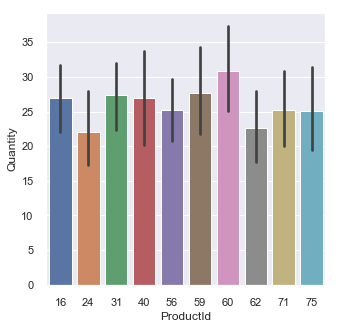

In [291]:
#Visualize the mean of top 10 product sales 
plt.figure(figsize=(5,5))
ax = sns.barplot(x="ProductId", y="Quantity", data=dftop10)

> We can see that the mean of units sold between product Ids are pretty similar. We will conduct a hypothesis test to confirm if the means are actually similar or if these similarities are due to chance.

##### Visually check normality

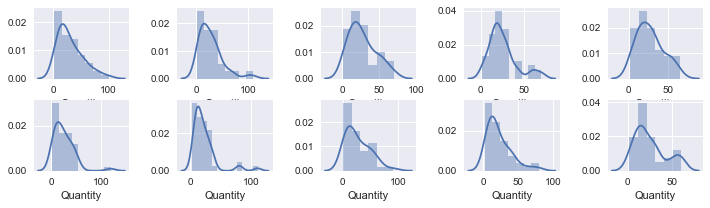

In [114]:
PIds = [60, 59, 31, 56, 16, 75, 24, 40, 62, 71]

fig, axes = plt.subplots(2,5, figsize=(12, 3))
plt.subplots_adjust(hspace = 0.3, wspace = 0.5)

for i, ax in zip(PIds, axes.flat):
    df = dfBestSeller2.loc[dfBestSeller2['ProductId'] == i]['Quantity']
    sns.distplot(df, ax=ax)
plt.show()

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [115]:
PIds = [60, 59, 31, 56, 16, 75, 24, 40, 62, 71]
for i, value in enumerate(PIds):
    df = dfBestSeller2.loc[dfBestSeller2['ProductId'] == value]['Quantity']
    print('{}.{}'.format(i+1,scs.shapiro(df)))

1.(0.9093694686889648, 0.0008774914313107729)
2.(0.8504878282546997, 8.21371122583514e-06)
3.(0.9390310645103455, 0.011232258751988411)
4.(0.8743551969528198, 7.575890776934102e-05)
5.(0.9496062994003296, 0.05767016485333443)
6.(0.8007105588912964, 2.0126001345488476e-06)
7.(0.6939018964767456, 5.095299737689629e-09)
8.(0.9039749503135681, 0.002176965121179819)
9.(0.8706983327865601, 8.089869515970349e-05)
10.(0.8940113186836243, 0.0009574673022143543)


> Shapiro test p-values < 0.05; therefore, we reject the null hypothesis (normality assumption is not met). 
We will continue using an ANOVA test since our sample sizes are the same and ANOVA remains robust under that condition

## ANOVA

In [123]:
#Create same size sample groups to ensure reliable results
PIds = [60, 59, 31, 56, 16, 75, 24, 40, 62, 71]
dfANOVA = pd.DataFrame() #creates a new dataframe that's empty
for i, value in enumerate(PIds):
    df = dfBestSeller2.loc[dfBestSeller2['ProductId'] == value]
    sample = df.sample(replace=False, n=40)
    dfANOVA = dfANOVA.append(sample, ignore_index = True)

In [124]:
dfANOVA['ProductId'].value_counts()

75    40
71    40
62    40
60    40
59    40
56    40
40    40
31    40
24    40
16    40
Name: ProductId, dtype: int64

In [125]:
#ANOVA
formula = 'Quantity ~ C(ProductId)'
lm = ols(formula, dfANOVA).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq     df         F   PR(>F)
C(ProductId)    1318.2525    9.0  0.373602  0.94741
Residual      152901.3250  390.0       NaN      NaN


> - F-statistic for ANOVA is greater than 0.05 (our alpha level) therefore we fail to reject the null hypothesis. We have significant evidence to confirm that there is no difference between the means of the top 10 best seller products.
- Since group sizes were equal there is no need to confirm normality of residuals and equal variances of residuals since ANOVA test remains robust for such violations (if they existed)

## Conclusions, Business Recommendations & Future Work

##### Conclusions
- Shapiro test p-values < 0.05; therefore, we rejected the null hypothesis (normality assumption is not met). 
- We used an ANOVA test since our sample sizes were the same and ANOVA remains robust under that condition
- ANOVA test was used to analyze the differences (if any) between mean sales of the top 10 best seller products
- F-Statistic > 0.05, therefore we do have significant evidence to reject H0.
- The conclusion of this experiment is that among the top 10 best seller products, there is no particular product driving sales. Therefore, we can conclude that Northwind customers are not loyal to the company due to the availability of a particular product.

##### Business Recommendations
- Study the marketing campaigns used for the top 10 best seller products and learn from them as they all have similar effect in sales
- Negotiate better terms with top 10 best seller product suppliers
- Continue collecting data for the top 10 best seller to perform product-pairs that significantly influence product sales

##### Future Work
- Study the product pairs that improve sales

# Hypothesis 5 - Effect of Discount on Product Quantity Sales

- H0: There is no difference between the mean quantity products sold with discounts and without discounts

> $H_0: \mu_d = \mu_n$

- Ha: The mean of the quantity of products sold with discounts is different than the mean of the quantity of products sold without discount

> $H_a:  \mu_d  !=  \mu_n$

## Data Exploration

In [7]:
dfOrderDetail = pd.read_sql_query('''SELECT * FROM 'OrderDetail'
                            ;''', cnx)

In [9]:
#Check the number of products with discounts and their level
dfOrderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [15]:
#Will keep rows with significant number of row counts to have a better testing
DiscountLevel = (dfOrderDetail['Discount'] == 0.00) | (dfOrderDetail['Discount'] == 0.05) | (dfOrderDetail['Discount'] == 0.10) | (dfOrderDetail['Discount'] == 0.15) | (dfOrderDetail['Discount'] == 0.20) | (dfOrderDetail['Discount'] == 0.25)

discountdf = dfOrderDetail.loc[DiscountLevel]
discountdf['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

> Sample size between discount levels are very similar, which will make it ideal for the hypothesis testing. 
We will use the ANOVA test, which remains pretty robust for same size samples.

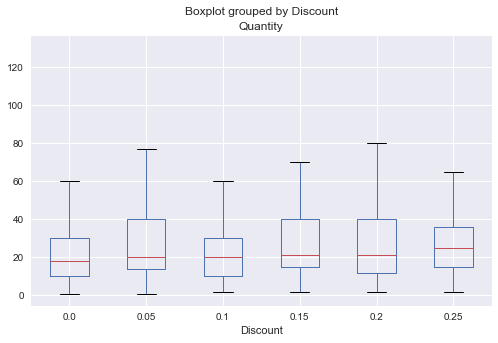

In [18]:
#Check for outliers in the data
discountdf.boxplot('Quantity', by='Discount', figsize=(8, 5));

> No significant outliers in the data

##### Visually check normality

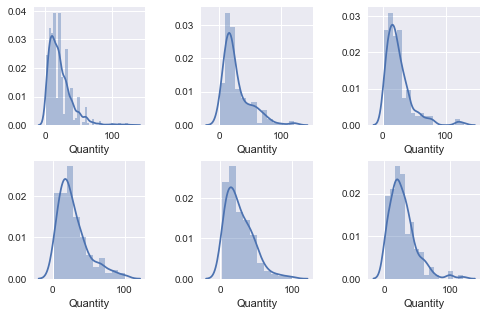

In [20]:
discountLevel = [0.00, 0.05, 0.10 , 0.15, 0.20, 0.25]

fig, axes = plt.subplots(2,3, figsize=(8, 5))
plt.subplots_adjust(hspace = 0.3, wspace = 0.5)

for i, ax in zip(discountLevel, axes.flat):
    df = discountdf.loc[discountdf['Discount'] == i]['Quantity']
    sns.distplot(df, ax=ax)
plt.show()

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [21]:
discountLevel = [0.00, 0.05, 0.10 , 0.15, 0.20, 0.25]
for i, value in enumerate(discountLevel):
    df = discountdf.loc[discountdf['Discount'] == value]['Quantity']
    print('{}.{}'.format(i+1,scs.shapiro(df)))

1.(0.8434571027755737, 3.803856556577728e-34)
2.(0.8356332778930664, 3.5543719660233175e-13)
3.(0.8002723455429077, 4.159971249851485e-14)
4.(0.8827876448631287, 8.372069704165597e-10)
5.(0.9130357503890991, 3.249125413162801e-08)
6.(0.8902021646499634, 2.6962121424389807e-09)


> Shapiro test shows that sample groups are not normal. We will continue with the ANOVA test since the group sizes are equal and ANOVA remains robust to normality violations with same group sizes.

## ANOVA

- An ANOVA test will be used to check if any of the mean quantity products differ by discount level
- Equal variance and normality assumptions were not met, but ANOVA remains robust for equal sized sample groups

In [81]:
#Create same size sample groups to ensure reliable results
discountLevel = [0.00, 0.05, 0.10 , 0.15, 0.20, 0.25]
dfANOVA = pd.DataFrame() #creates a new dataframe that's empty
for i, value in enumerate(discountLevel):
    df = discountdf.loc[discountdf['Discount'] == value]
    sample = df.sample(replace=False, n=154)
    dfANOVA = dfANOVA.append(sample, ignore_index = True)

In [31]:
dfANOVA['Discount'].value_counts()

0.10    154
0.15    154
0.20    154
0.05    154
0.25    154
0.00    154
Name: Discount, dtype: int64

In [44]:
#ANOVA
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, dfANOVA).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F    PR(>F)
C(Discount)   12352.343074    5.0  6.178832  0.000012
Residual     367041.902597  918.0       NaN       NaN


> The ANOVA test p-value < 0.05, therefore we have enough evidence to reject H0 and infere that discount have some influence in the quantity of products sold

##### Check Effect Size

In [45]:
#This code was taken from Britta Bettendorf Notebook
#GitHub https://github.com/BrittaInData

def anova_effect_size(aov):       
    """ This function takes the Anova table performed with statsmodels
    and appends two effect size measures: eta-squared and omega-squared. """
    
    # mean squared
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    # eta-squared (η2) 
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    # omega-squared (ω2)
    num = (aov[:-1]['sum_sq'] - (aov[:-1]['df']*aov['mean_sq'][-1]))
    denom = (sum(aov['sum_sq']) + aov['mean_sq'][-1])
    aov['omega_sq'] = num / denom    
    
    return aov

anova_effect_size(table)

,sum_sq,df,F,PR(>F),mean_sq,eta_sq,omega_sq
C(Discount),12352.343074,5.0,6.178832,0.000012,2470.468615,0.032558,0.02726
Residual,367041.902597,918.0,NaN,NaN,399.827781,NaN,NaN


> According to both measures (around 0.03), the discount only has a small effect. Will check which discount level is the most different.

##### Post-Hoc Testing
Will use a tukey test to see which discount has the most significant influence

In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [49]:
mod = MultiComparison(dfANOVA.Quantity, dfANOVA.Discount)
mc_results = mod.tukeyhsd()

In [50]:
print(mod.tukeyhsd())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   9.7468   3.2394 16.2541  True 
 0.0    0.1    7.2922   0.7848 13.7996  True 
 0.0    0.15  10.6299   4.1225 17.1373  True 
 0.0    0.2    9.0195   2.5121 15.5269  True 
 0.0    0.25  10.2143   3.7069 16.7217  True 
 0.05   0.1   -2.4545  -8.9619  4.0528 False 
 0.05   0.15   0.8831  -5.6243  7.3905 False 
 0.05   0.2   -0.7273  -7.2347  5.7801 False 
 0.05   0.25   0.4675  -6.0399  6.9749 False 
 0.1    0.15   3.3377  -3.1697  9.845  False 
 0.1    0.2    1.7273  -4.7801  8.2347 False 
 0.1    0.25   2.9221  -3.5853  9.4295 False 
 0.15   0.2   -1.6104  -8.1178  4.897  False 
 0.15   0.25  -0.4156   -6.923  6.0918 False 
 0.2    0.25   1.1948  -5.3126  7.7022 False 
---------------------------------------------


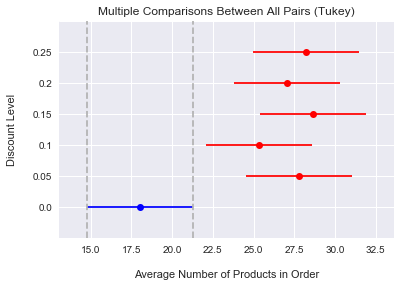

In [51]:
#Visiualize significant differences in a plot with one confidence interval per group
mc_results.plot_simultaneous(comparison_name=0.0, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

> TukeyHSDResults.plot_simultaneous color in RED all significantly different groups. The most different one (the one with higher number of products in order) is 0.15 discount level.

## Conclusions, Business Recommendations & Future Work